In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv
import pandas as pd

np.set_printoptions(precision=4, suppress=True)
mpl.rcParams['figure.dpi'] = mpl.rcParamsDefault['figure.dpi']*2

import mdpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overview

We provide code for a few different ways of estimating variance and second moments of various cumulants in a discrete MDP.
In this notebook we focus on the case where linear function approximation is used.

# Problem Setup

We define and solve an MDP for its value function and its variance (using Sobel's method).

The MDP in questions is a bounded random walk used by [Tamar et. al (see pg. 19)](http://www.jmlr.org/papers/volume17/14-335/14-335.pdf).

There are 32 states (including the terminal state), with the initial state being $s_{0}$ and the terminal state being $s_{31}$.
The transitions from a state go to the "right" (i.e., $s_{n} \rightarrow s_{n+1}$ with probability $p = 0.7$, and to the left $s_{n} \rightarrow s_{n-1}$ with probability $(1-p)$.
Rewards are -1 for all transitions from non-terminal states, and a discount factor of unity.

In [2]:
# MDP solved analytically
ns = 32
I = np.eye(ns)

# Probability of transitioning from state s_i --> s_j = P[i,j]
p_trans = 0.7
P = np.diag(np.ones(ns-1), 1) * p_trans
P = P + np.diag(np.ones(ns-1), -1)* (1 - p_trans)
# Start and terminal states
P[0, :] = 0
P[0, 1] = 1
P[-1, :] = 0
P[-1, 0] = 1
# Adjust state after start 
P[1, 0] = 0
P[1, 1] = (1 - p_trans)


# Expected reward for transitioning from s_i --> s_j = R[i,j]
R = np.zeros((ns, ns))
# -1 Reward for non-terminal transitions
R[:,:] = -1
R[0,:] = 0  # start state 
R[-1,:] = 0 # transitions from terminal state have zero reward
R[-2, -1] = 0
r = np.sum(P*R, axis=1)

# State-dependent discount
gvec = np.ones(ns)
gvec[0]  = 0 # start state
gvec[-1] = 0 # terminal state

G = np.diag(gvec)

# Value function (expected Monte Carlo return)
v_pi = pinv(I - P @ G) @ r
v_pi[-1] = 0 # hacky way of setting terminal state value to zero

# Compute stationary distribution for transition matrix
d_pi = mdpy.stationary(P)
D = np.diag(d_pi)


# From Sobel, setting up variance Bellman equation
T = -v_pi**2
for i in range(ns):
    for j in range(ns):
        T[i] += P[i,j] * (R[i,j] + gvec[j]*v_pi[j])**2

# Alternatively,
T = (P * (R + G @ v_pi)**2) @ np.ones(ns) - v_pi**2
        
# Solve Bellman equation for variance of return
v_var = pinv(I - P @ G @ G) @ T 
v_var[-1] = 0 # hacky way of setting terminal state variance to zero

print('v_pi:\n', v_pi)
print('per-state variance:\n', v_var)

v_pi:
 [-72.125  -72.125  -70.6964 -68.6556 -66.3524 -63.9367 -61.4729 -58.9884
 -56.495  -53.9979 -51.4991 -48.9996 -46.4998 -43.9999 -41.5    -39.     -36.5
 -34.     -31.5    -29.     -26.5    -24.     -21.5    -19.     -16.5    -14.
 -11.5     -9.      -6.5     -4.      -1.5      0.    ]
per-state variance:
 [ 359.2969  359.2969  358.6846  354.8112  347.4901  337.6721  326.3215
  314.1111  301.4443  288.5441  275.5276  262.4543  249.3538  236.2402
  223.1205  209.9979  196.8741  183.7496  170.6248  157.4999  144.375
  131.25    118.125   105.       91.875    78.75     65.625    52.5
   39.375    26.25     13.125     0.    ]


In [3]:
dct = {s: {} for s in range(1, ns-1)}
for s, d in dct.items():
    d['state'] = s
    d['value'] = v_pi[s]
    d['variance'] = v_var[s]
df = pd.DataFrame(dct)
print(df.T)

    state      value    variance
1     1.0 -72.125000  359.296875
2     2.0 -70.696429  358.684630
3     3.0 -68.655612  354.811244
4     4.0 -66.352405  347.490060
5     5.0 -63.936745  337.672097
6     6.0 -61.472891  326.321501
7     7.0 -58.988382  314.111069
8     8.0 -56.495021  301.444270
9     9.0 -53.997866  288.544068
10   10.0 -51.499085  275.527599
11   11.0 -48.999608  262.454337
12   12.0 -46.499832  249.353751
13   13.0 -43.999928  236.240173
14   14.0 -41.499969  223.120480
15   15.0 -38.999987  209.997931
16   16.0 -36.499994  196.874056
17   17.0 -33.999998  183.749571
18   18.0 -31.499999  170.624806
19   19.0 -29.000000  157.499912
20   20.0 -26.500000  144.374961
21   21.0 -24.000000  131.249982
22   22.0 -21.500000  118.124992
23   23.0 -19.000000  104.999996
24   24.0 -16.500000   91.874998
25   25.0 -14.000000   78.749999
26   26.0 -11.500000   65.625000
27   27.0  -9.000000   52.500000
28   28.0  -6.500000   39.375000
29   29.0  -4.000000   26.250000
30   30.0 

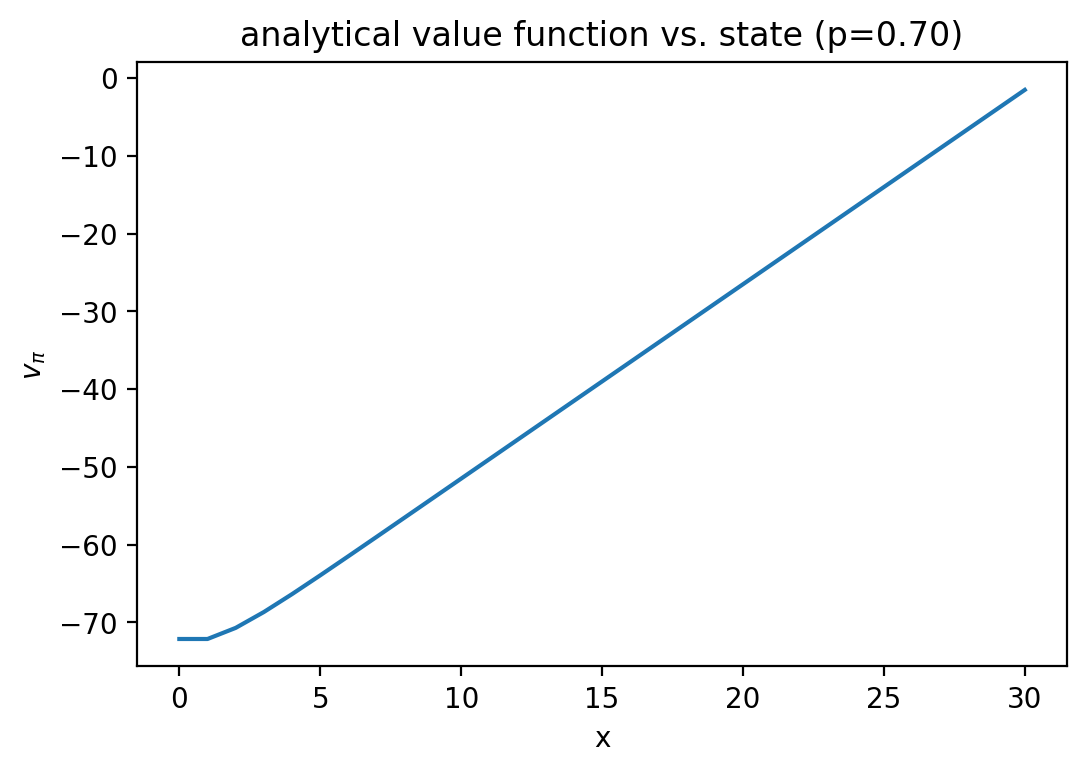

In [4]:
fig, ax = plt.subplots()
ax.plot(v_pi[:-1])
ax.set_xlabel('x')
ax.set_ylabel('$v_\pi$')
ax.set_title('analytical value function vs. state (p=%0.2f)'%(p_trans))

## Second Moment of Return

We calculate the second moment of the return following the approach in the VTD paper (White & White, 2016).

In [5]:
# Using the VTD paper to calculate second moments of the return.
# Note that here we are using the most accurate values for everything
# in order to check the equations.
Pbar = np.zeros((ns, ns))
Rbar = np.zeros((ns,ns))
rbar = np.zeros(ns)

# Specify parameters
lvec = np.ones(ns) # λ

# Calculate R-bar transition matrix
for i in range(ns):
    for j in range(ns):
        Rbar[i,j] = R[i,j]**2 + 2*gvec[j]*lvec[j]*R[i,j]*v_pi[j]

# Calculate r-bar vector
for i in range(ns):
    for j in range(ns):
        rbar[i] += P[i,j]*Rbar[i,j]

# Calculate P-bar
for i in range(ns):
    for j in range(ns):
        Pbar[i,j] += P[i,j]*(gvec[j]**2)*(lvec[j]**2)
        
        
# Calculate second moment of return
g_second = pinv(I - Pbar) @ rbar
g_second[-1] = 0 # hacky way of setting terminal SM to zero

# Print the results
print("Second moment of return:\n", g_second)
print("Estimated variance via second moment of return:\n", g_second - v_pi**2)
print("Sobel variance:\n", v_var)


# An alternative approach, which is somewhat more concise
# Second moment of return
# rr = (P*R**2) @ np.ones(ns) + (2*P @ G * R) @ v_pi
# vv = pinv(I - P @ G @ G)@(rr)

Second moment of return:
 [ 5561.3125  5561.3125  5356.6696  5068.4043  4750.1317  4425.5795
  4105.2378  3793.7403  3493.1316  3204.3136  2927.6834  2663.4159
  2411.5881  2172.2338  1945.3679  1730.9969  1529.1236  1339.7494
  1162.8747   998.4999   846.625    707.25     580.375    466.       364.125
   274.75     197.875    133.5       81.625     42.25      15.375      0.    ]
Estimated variance via second moment of return:
 [ 359.2969  359.2969  358.6846  354.8112  347.4901  337.6721  326.3215
  314.1111  301.4443  288.5441  275.5276  262.4543  249.3538  236.2402
  223.1205  209.9979  196.8741  183.7496  170.6248  157.4999  144.375
  131.25    118.125   105.       91.875    78.75     65.625    52.5
   39.375    26.25     13.125     0.    ]
Sobel variance:
 [ 359.2969  359.2969  358.6846  354.8112  347.4901  337.6721  326.3215
  314.1111  301.4443  288.5441  275.5276  262.4543  249.3538  236.2402
  223.1205  209.9979  196.8741  183.7496  170.6248  157.4999  144.375
  131.25    118.1

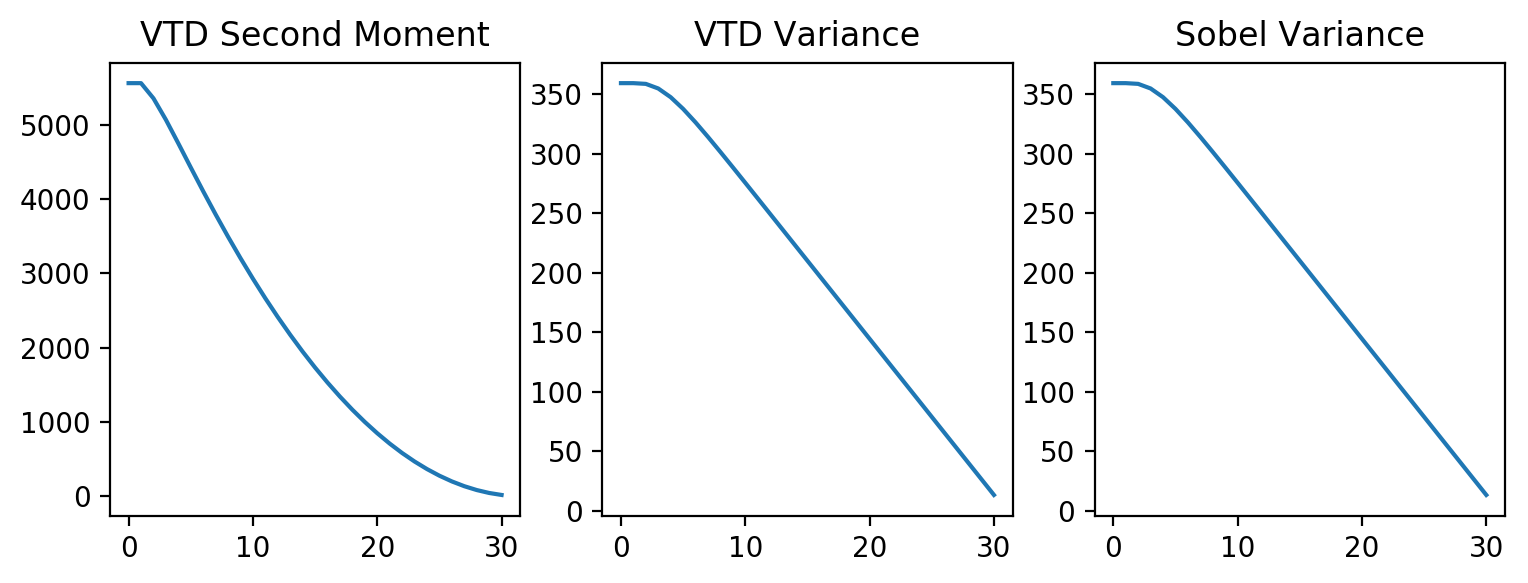

In [6]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(9, 3)

ax = axes[0]
ax.plot(g_second[:-1])
ax.set_title('VTD Second Moment')

ax = axes[1]
ax.plot((g_second - v_pi**2)[:-1])
ax.set_title('VTD Variance')

ax = axes[2]
ax.plot((v_var)[:-1])
ax.set_title('Sobel Variance')

# Linear Function Approximation 

Linear function approximation is an important test case when analyzing the utility of a learning algorithm.

Here we use a scheme where the features are $\phi(s_{i}) = [1, s+1]$, where $s_{i}$ is state $i$.

For variance approximation, we include an additional feature, $x^{2}$, so that $\phi_{var}(s) = [1, s+1, (s+1)^{2}]$

In [7]:
# list of features
flst = [[1, s+1] for s in range(ns)]
# feature matrix
X = np.array(flst)
# set terminal state features to zero vector
X[-1] *= 0

# Variance features
X_bar = np.array([[1, s+1, (s+1)**2] for s in range(ns)])
X_bar[-1] = 0

## TD(λ) fixed point

We compute the weights that TD(λ) converges to asymptotically, and the associated value function.

In [8]:
# Compute TD(λ) fixed point
L = np.eye(ns)*0.0 # λ=0.0
w_hat = pinv(X.T @ D @ pinv(I - P @ G @ L) @ (I - P @ G) @ X) @ X.T @ D @ pinv(I - P @ G @ L) @ r
w_hat = mdpy.td_weights(P, r, G, L, X)
v_hat = X @ w_hat

print('TD(λ) fixed point weights:\n', w_hat)
print('TD(λ) approximate value function:\n', v_hat)
print('v_pi - v_hat:\n', v_pi - v_hat)
print('Squared error due to bias:\n', np.sum((v_pi - v_hat)**2))
print('RMSE:', np.sqrt(np.sum((v_pi - v_hat)**2)))

TD(λ) fixed point weights:
 [-74.3589   2.2339]
TD(λ) approximate value function:
 [-72.125  -69.8911 -67.6572 -65.4233 -63.1894 -60.9555 -58.7216 -56.4877
 -54.2538 -52.0199 -49.786  -47.5521 -45.3182 -43.0843 -40.8504 -38.6165
 -36.3826 -34.1487 -31.9148 -29.6809 -27.447  -25.2131 -22.9792 -20.7453
 -18.5114 -16.2775 -14.0436 -11.8097  -9.5758  -7.3419  -5.108    0.    ]
v_pi - v_hat:
 [ 0.     -2.2339 -3.0392 -3.2323 -3.163  -2.9812 -2.7513 -2.5007 -2.2412
 -1.978  -1.7131 -1.4475 -1.1816 -0.9156 -0.6496 -0.3835 -0.1174  0.1487
  0.4148  0.6809  0.947   1.2131  1.4792  1.7453  2.0114  2.2775  2.5436
  2.8097  3.0758  3.3419  3.608   0.    ]
Squared error due to bias:
 139.678165777
RMSE: 11.8185517631


In [9]:
# Compute TD(λ) fixed point
L = np.eye(ns)*0.95 # λ=0.95
w_hat = pinv(X.T @ D @ pinv(I - P @ G @ L) @ (I - P @ G) @ X) @ X.T @ D @ pinv(I - P @ G @ L) @ r
w_hat = mdpy.td_weights(P, r, G, L, X)
v_hat = X @ w_hat

print('TD(λ) fixed point weights:\n', w_hat)
print('TD(λ) approximate value function:\n', v_hat)
print('v_pi - v_hat:\n', v_pi - v_hat)
print('Squared error due to bias:\n', np.sum((v_pi - v_hat)**2))
print('RMSE:', np.sqrt(np.sum((v_pi - v_hat)**2)))

TD(λ) fixed point weights:
 [-77.9992   2.4485]
TD(λ) approximate value function:
 [-75.5508 -73.1023 -70.6539 -68.2054 -65.757  -63.3085 -60.8601 -58.4116
 -55.9632 -53.5147 -51.0663 -48.6178 -46.1694 -43.7209 -41.2725 -38.824
 -36.3756 -33.9271 -31.4787 -29.0302 -26.5818 -24.1333 -21.6849 -19.2364
 -16.788  -14.3395 -11.8911  -9.4426  -6.9942  -4.5457  -2.0973   0.    ]
v_pi - v_hat:
 [ 3.4258  0.9773 -0.0426 -0.4502 -0.5954 -0.6282 -0.6128 -0.5768 -0.5319
 -0.4832 -0.4328 -0.3818 -0.3305 -0.279  -0.2275 -0.176  -0.1244 -0.0729
 -0.0213  0.0302  0.0818  0.1333  0.1849  0.2364  0.288   0.3395  0.3911
  0.4426  0.4942  0.5457  0.5973  0.    ]
Squared error due to bias:
 17.0545350253
RMSE: 4.12971367353


## Least-Squares / Monte Carlo Approximation

We can also calculate the fixed point for when $\lambda=1$ and we are approximating the Monte Carlo return. 

This is also called the least-squares approximation, because we are essentially performing a weighted least-squares regression on the value function.

In [10]:
# Compute least-squares / TD(1) fixed point
w_lsq = pinv(X.T @ D @ X) @ X.T @ D @ pinv(I - P @ G) @ r
v_lsq = X @ w_lsq

print('Least-squares weights:\n', w_lsq)
print('Least-squares approximate value function:\n', v_lsq)
print('v_pi - v_lsq:\n', v_pi - v_lsq)
print('Error due to bias (least-squares):\n', np.sum((v_pi - v_lsq)**2))

Least-squares weights:
 [-78.3252   2.4683]
Least-squares approximate value function:
 [-75.8568 -73.3885 -70.9202 -68.4519 -65.9836 -63.5153 -61.047  -58.5786
 -56.1103 -53.642  -51.1737 -48.7054 -46.2371 -43.7687 -41.3004 -38.8321
 -36.3638 -33.8955 -31.4272 -28.9589 -26.4905 -24.0222 -21.5539 -19.0856
 -16.6173 -14.149  -11.6806  -9.2123  -6.744   -4.2757  -1.8074   0.    ]
v_pi - v_lsq:
 [ 3.7318  1.2635  0.2238 -0.2037 -0.3688 -0.4215 -0.4259 -0.4097 -0.3847
 -0.3559 -0.3254 -0.2942 -0.2628 -0.2312 -0.1995 -0.1679 -0.1362 -0.1045
 -0.0728 -0.0411 -0.0095  0.0222  0.0539  0.0856  0.1173  0.149   0.1806
  0.2123  0.244   0.2757  0.3074  0.    ]
Error due to bias (least-squares):
 17.3263153063


# Variance Estimation Fixed Points

## Checking results for LFA

We check what happens when we use the value function derived under LFA with our simple representation.

### TD(λ) Fixed Point

We first examine the various quantities using the value function that TD(λ) converges to (although any value function can be substituted for `v_hat`).
Similar to how the λ-return requires a value function in order to be well-defined, the value function also determines the approximation target for the TD-δ^2 algorithm and the second moment (estimated as part of VTD).

If we assume that the value function is fixed (say, at convergence), then it becomes possible to calculate the epi-rewards used in TD-δ^2 or VTD.
From there it is straightforward to compute their fixed points.
We note that you can use any arbitrary value function in lieu of the one found by TD(λ)-- in fact, you can use the value function found for one λ to estimate the second moment or variance of the λ-return, which we've been calling the κ-return (kappa-return) for the sake of distinction.

NB: Here we set κ=1, for simplicity and also because that appears to be what Tamar et. al. were doing; for the same reason, we use [1, x, x^2] as the representation for the second moment/TD-δ^2 algorithms rather than the [1, x] representation used for estimating the value function.

Furthermore, once function approximation of these epi-returns is brought into the mix, it's possible to have different amounts of bootstrapping, so we incorporate yet *another* parameter, λ-bar (or $\bar{\lambda}$) to reflect that we might use different bootstrapping in the VTD or TD-δ^2 algorithms.

We also include the estimate for the variance of the return as calculated by Sobel's method when using the approximate value function (`v_hat`), which might be worth including in the comparison. 

### λ = 0.0

In [11]:
# Compute TD(λ) fixed point
L = np.eye(ns)*0.0
# w_hat = pinv(X.T @ D @ pinv(I - P @ G @ L) @ (I - P @ G) @ X) @ X.T @ D @ pinv(I - P @ G @ L) @ r
w_hat = mdpy.td_weights(P, r, G, L, X)
v_hat = X @ w_hat

# Bias of approximate value function
bias = v_pi - v_hat

# Variance using Sobel's method and approximate value function
T_hat = (P * (R + G @ v_hat)**2) @ np.ones(ns) - v_hat**2
        
# Solve Bellman equation for variance of return w/ approx value function
var_hat = pinv(I - P @ G @ G) @ T_hat
var_hat[-1] = 0 # terminal state

# Second moment target (see earlier in notebook for alternate calculation method)
r_bar = (P*R**2) @ np.ones(ns) + (2*P @ G * R) @ v_hat
g_second = pinv(I - P @ G @ G)@(r_bar)
g_second[-1] = 0 # hacky way of setting terminal SM to zero

# TD error matrix, for error given transition i-->j
Δ = np.zeros_like(R)
for i in range(ns):
    for j in range(ns):
        Δ[i,j] = (R[i,j] + gvec[j]*v_hat[j] - v_hat[i])

# Expected TD-error
δ = (P*Δ) @ np.ones(ns)
δ[-1] = 0 # terminal state
        
# Expected δ^2
δ_sq = (P * Δ**2) @ np.ones(ns)
δ_sq[-1] = 0 # terminal state

# δ-return
gd = pinv(I - P @ G) @ δ

# δ^2-return
gd_sq = pinv(I - P @ G @ G) @ δ_sq
gd_sq[-1] = 0 # terminal state

# Second moment of δ-return (for MSE comparison)
dd = (P * Δ**2) @ np.ones(ns) + (2*P @ G * Δ) @ gd
gd_second = pinv(I - P @ G @ G)@(dd)
gd_second[-1] = 0 # terminal state

###################### Function Approximation ######################
K_bar = np.eye(ns)               # kappa 
L_bar = np.eye(ns)               # λ-bar
G_bar = (G @ G @ K_bar @ K_bar)  # discount factor

# TD-δ^2 fixed point
w_tdsq = mdpy.td_weights(P, δ_sq, G_bar, L_bar, X_bar)
v_tdsq = X_bar @ w_tdsq

# Second moment method fixed point
w_sm   = mdpy.td_weights(P, r_bar, G_bar, L_bar, X_bar)
v_sm   = X_bar @ w_sm
v_vtd  = v_sm - v_hat**2

####################################################################
# Print summary of results
print("v_π:\n", v_pi)
print("v_hat:\n", v_hat)
print("(Sobel) Approximate variance of return:\n", var_hat)
print("(Sobel) True variance of return:\n", v_var)

# Variance and second moment
print('-'*80)
print('Expected TD-error:\n', δ)
print('Expected Squared TD-error:\n', δ_sq)
print("Second moment expected 'reward' (r-bar):\n", r_bar)
print('Approximate second moment return:\n', g_second)
print("δ^2-return:\n", gd_sq)

print('-'*80)
print('(FA) TD-δ^2 values:\n', v_tdsq)
print('(FA) VTD second moment values:\n', v_sm)
print('(FA) VTD variance values:\n', v_vtd)

# Neat results
print('-'*80)
# Bias is the δ-return
# print("bias:\n", v_pi-v_hat)
# print("δ-return:\n", gd)

# Second moment of δ-return is the expected squared error
# print("Second moment of delta-return:\n", gd_second)
# print("Expected squared error:\n", (v_pi - v_hat)**2 + v_var)



v_π:
 [-72.125  -72.125  -70.6964 -68.6556 -66.3524 -63.9367 -61.4729 -58.9884
 -56.495  -53.9979 -51.4991 -48.9996 -46.4998 -43.9999 -41.5    -39.     -36.5
 -34.     -31.5    -29.     -26.5    -24.     -21.5    -19.     -16.5    -14.
 -11.5     -9.      -6.5     -4.      -1.5      0.    ]
v_hat:
 [-72.125  -69.8911 -67.6572 -65.4233 -63.1894 -60.9555 -58.7216 -56.4877
 -54.2538 -52.0199 -49.786  -47.5521 -45.3182 -43.0843 -40.8504 -38.6165
 -36.3826 -34.1487 -31.9148 -29.6809 -27.447  -25.2131 -22.9792 -20.7453
 -18.5114 -16.2775 -14.0436 -11.8097  -9.5758  -7.3419  -5.108    0.    ]
(Sobel) Approximate variance of return:
 [ 329.8241  647.0738  757.6931  778.5213  761.5468  729.0507  690.5817
  650.2322  609.7563  569.9055  531.002   493.1838  456.5101  421.0063
  386.6832  353.5455  321.5952  290.8332  261.2598  232.8751  205.6792
  179.6723  154.8542  131.225   108.7846   87.5332   67.4706   48.5969
   30.9122   14.4162   -0.8908    0.    ]
(Sobel) True variance of return:
 [ 359.

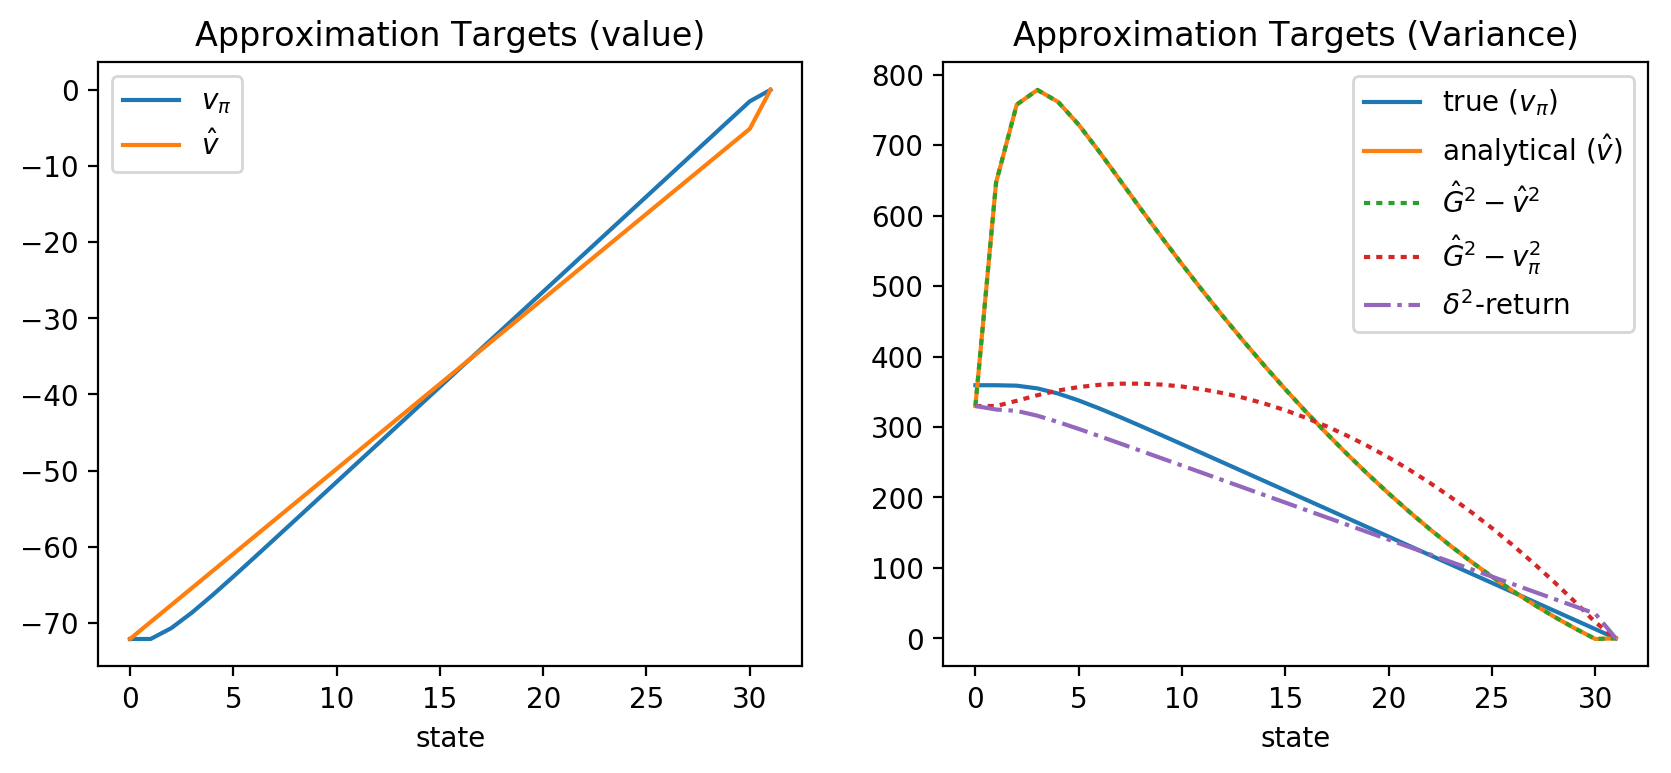

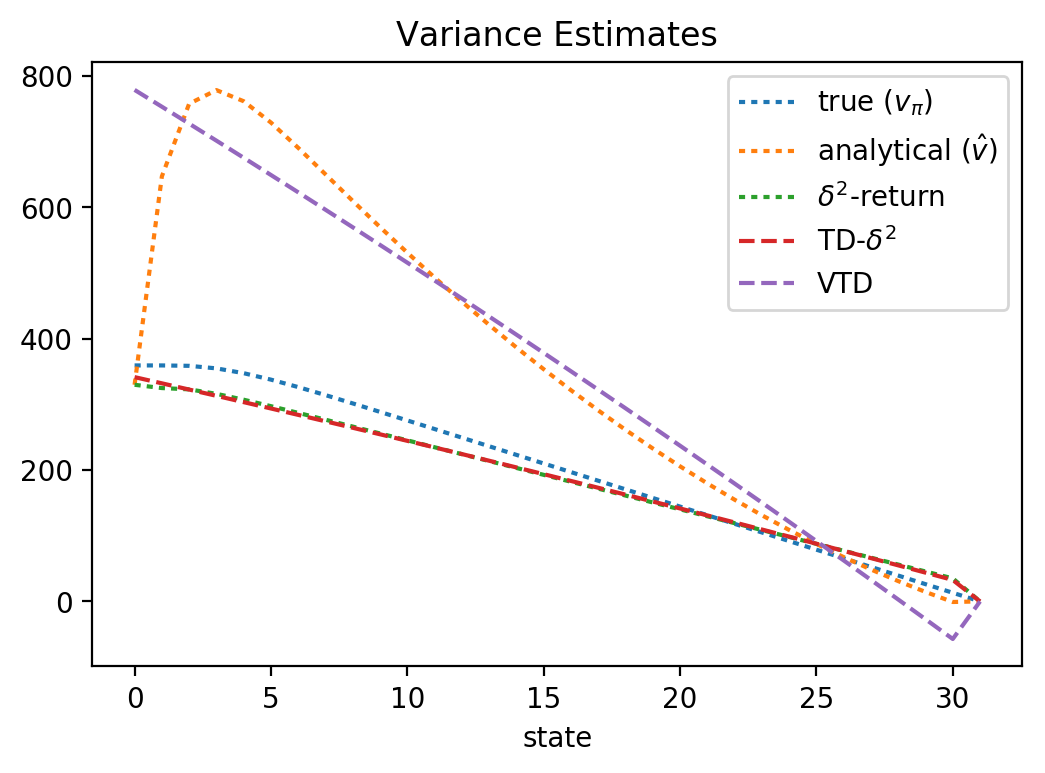

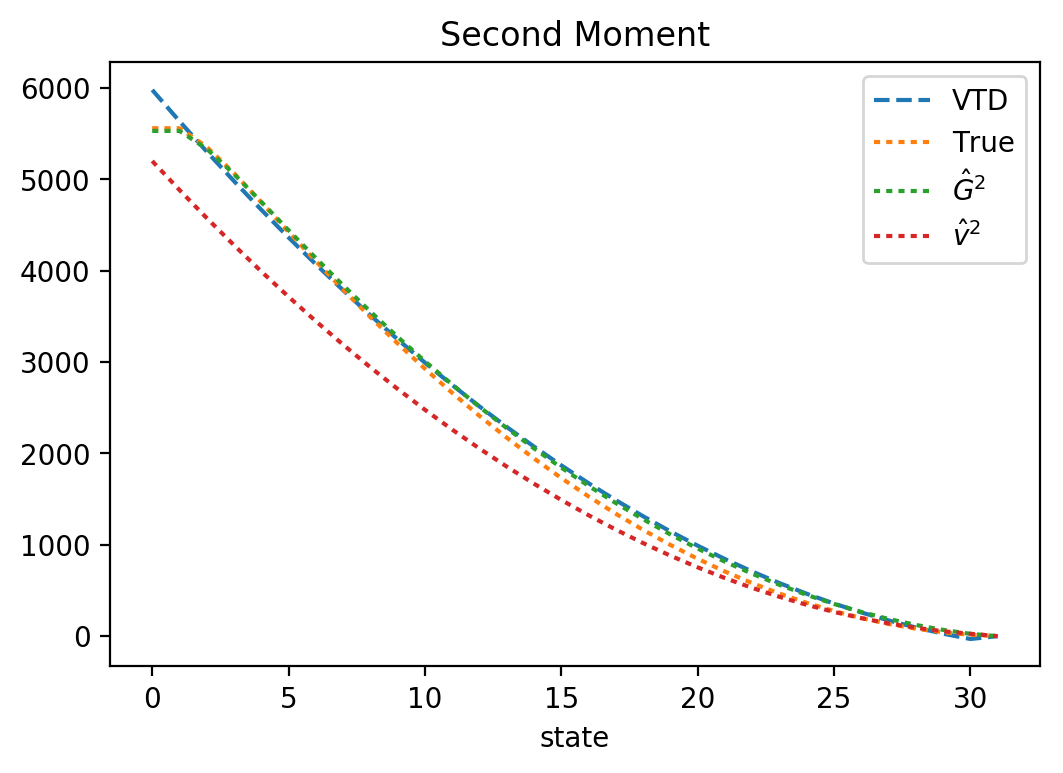

In [12]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# Value function
ax = axes[0]
ax.plot(v_pi, label='$v_{\pi}$')
ax.plot(v_hat, label='$\hat{v}$')

ax.set_title('Approximation Targets (value)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

# Variance
ax = axes[1]
ax.plot(v_var, label='true ($v_{\pi}$)', linestyle='-')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle='-')
ax.plot((g_second - v_hat**2),  label='$\hat{G}^{2} - \hat{v}^{2}$', linestyle=':')
ax.plot((g_second - v_pi**2),  label='$\hat{G}^{2} - v_{\pi}^{2}$', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle='-.')

ax.set_title('Approximation Targets (Variance)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Estimates
fig, ax = plt.subplots()

ax.plot(v_var, label='true ($v_{\pi}$)', linestyle=':')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle=':')
ax.plot(v_tdsq, label='TD-$\delta^2$', linestyle='--')
ax.plot(v_vtd,  label='VTD', linestyle='--')

ax.set_title('Variance Estimates')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Second Moment
fig, ax = plt.subplots()

ax.plot(v_sm, label='VTD', linestyle='--')
ax.plot(v_var + v_pi**2, label='True', linestyle=':')
ax.plot(g_second, label='$\hat{G}^{2}$', linestyle=':')
ax.plot(v_hat**2, label='$\hat{v}^{2}$', linestyle=':')

ax.set_title('Second Moment')
ax.set_xlabel('state')
ax.set_ylabel('')

ax.legend()
plt.show()

### λ = 1.0

In [13]:
# Compute TD(λ) fixed point
L = np.eye(ns)*1.0
w_hat = mdpy.td_weights(P, r, G, L, X)
v_hat = X @ w_hat

# Bias of approximate value function
bias = v_pi - v_hat

# Variance using Sobel's method and approximate value function
T_hat = (P * (R + G @ v_hat)**2) @ np.ones(ns) - v_hat**2
        
# Solve Bellman equation for variance of return w/ approx value function
var_hat = pinv(I - P @ G @ G) @ T_hat
var_hat[-1] = 0 # terminal state

# Second moment target (see earlier in notebook for alternate calculation method)
r_bar = (P*R**2) @ np.ones(ns) + (2*P @ G * R) @ v_hat
g_second = pinv(I - P @ G @ G)@(r_bar)
g_second[-1] = 0 # hacky way of setting terminal SM to zero

# TD error matrix, for error given transition i-->j
Δ = np.zeros_like(R)
for i in range(ns):
    for j in range(ns):
        Δ[i,j] = (R[i,j] + gvec[j]*v_hat[j] - v_hat[i])

# Expected TD-error
δ = (P*Δ) @ np.ones(ns)
δ[-1] = 0 # terminal state
        
# Expected δ^2
δ_sq = (P * Δ**2) @ np.ones(ns)
δ_sq[-1] = 0 # terminal state

# δ-return
gd = pinv(I - P @ G) @ δ

# δ^2-return
gd_sq = pinv(I - P @ G @ G) @ δ_sq
gd_sq[-1] = 0 # terminal state

# Second moment of δ-return (for MSE comparison)
dd = (P * Δ**2) @ np.ones(ns) + (2*P @ G * Δ) @ gd
gd_second = pinv(I - P @ G @ G)@(dd)
gd_second[-1] = 0 # terminal state

###################### Function Approximation ######################
K_bar = np.eye(ns)               # kappa 
L_bar = np.eye(ns)               # λ-bar
G_bar = (G @ G @ K_bar @ K_bar)  # discount factor

# TD-δ^2 fixed point
w_tdsq = mdpy.td_weights(P, δ_sq, G_bar, L_bar, X_bar)
v_tdsq = X_bar @ w_tdsq

# Second moment method fixed point
w_sm   = mdpy.td_weights(P, r_bar, G_bar, L_bar, X_bar)
v_sm   = X_bar @ w_sm
v_vtd  = v_sm - v_hat**2

####################################################################
# Print summary of results
print("v_π:\n", v_pi)
print("v_hat:\n", v_hat)
print("(Sobel) Approximate variance of return:\n", var_hat)
print("(Sobel) True variance of return:\n", v_var)

# Variance and second moment
print('-'*80)
print('Expected TD-error:\n', δ)
print('Expected Squared TD-error:\n', δ_sq)
print("Second moment expected 'reward' (r-bar):\n", r_bar)
print('Approximate second moment return:\n', g_second)
print("δ^2-return:\n", gd_sq)

print('-'*80)
print('(FA) TD-δ^2 values:\n', v_tdsq)
print('(FA) VTD second moment values:\n', v_sm)
print('(FA) VTD variance values:\n', v_vtd)

# Neat results
print('-'*80)
# Bias is the δ-return
# print("bias:\n", v_pi-v_hat)
# print("δ-return:\n", gd)

# Second moment of δ-return is the expected squared error
# print("Second moment of delta-return:\n", gd_second)
# print("Expected squared error:\n", (v_pi - v_hat)**2 + v_var)



v_π:
 [-72.125  -72.125  -70.6964 -68.6556 -66.3524 -63.9367 -61.4729 -58.9884
 -56.495  -53.9979 -51.4991 -48.9996 -46.4998 -43.9999 -41.5    -39.     -36.5
 -34.     -31.5    -29.     -26.5    -24.     -21.5    -19.     -16.5    -14.
 -11.5     -9.      -6.5     -4.      -1.5      0.    ]
v_hat:
 [-75.8568 -73.3885 -70.9202 -68.4519 -65.9836 -63.5153 -61.047  -58.5786
 -56.1103 -53.642  -51.1737 -48.7054 -46.2371 -43.7687 -41.3004 -38.8321
 -36.3638 -33.8955 -31.4272 -28.9589 -26.4905 -24.0222 -21.5539 -19.0856
 -16.6173 -14.149  -11.6806  -9.2123  -6.744   -4.2757  -1.8074   0.    ]
(Sobel) Approximate variance of return:
 [-202.9399  165.4448  315.4709  369.8884  383.4202  379.5188  368.2356
  353.878   338.2923  322.2696  306.1489  290.0757  274.1122  258.2851
  242.6058  227.0793  211.7076  196.4917  181.4318  166.5283  151.7811
  137.1903  122.7559  108.478    94.3564   80.3912   66.5825   52.9302
   39.4343   26.0948   12.9117    0.    ]
(Sobel) True variance of return:
 [ 359.

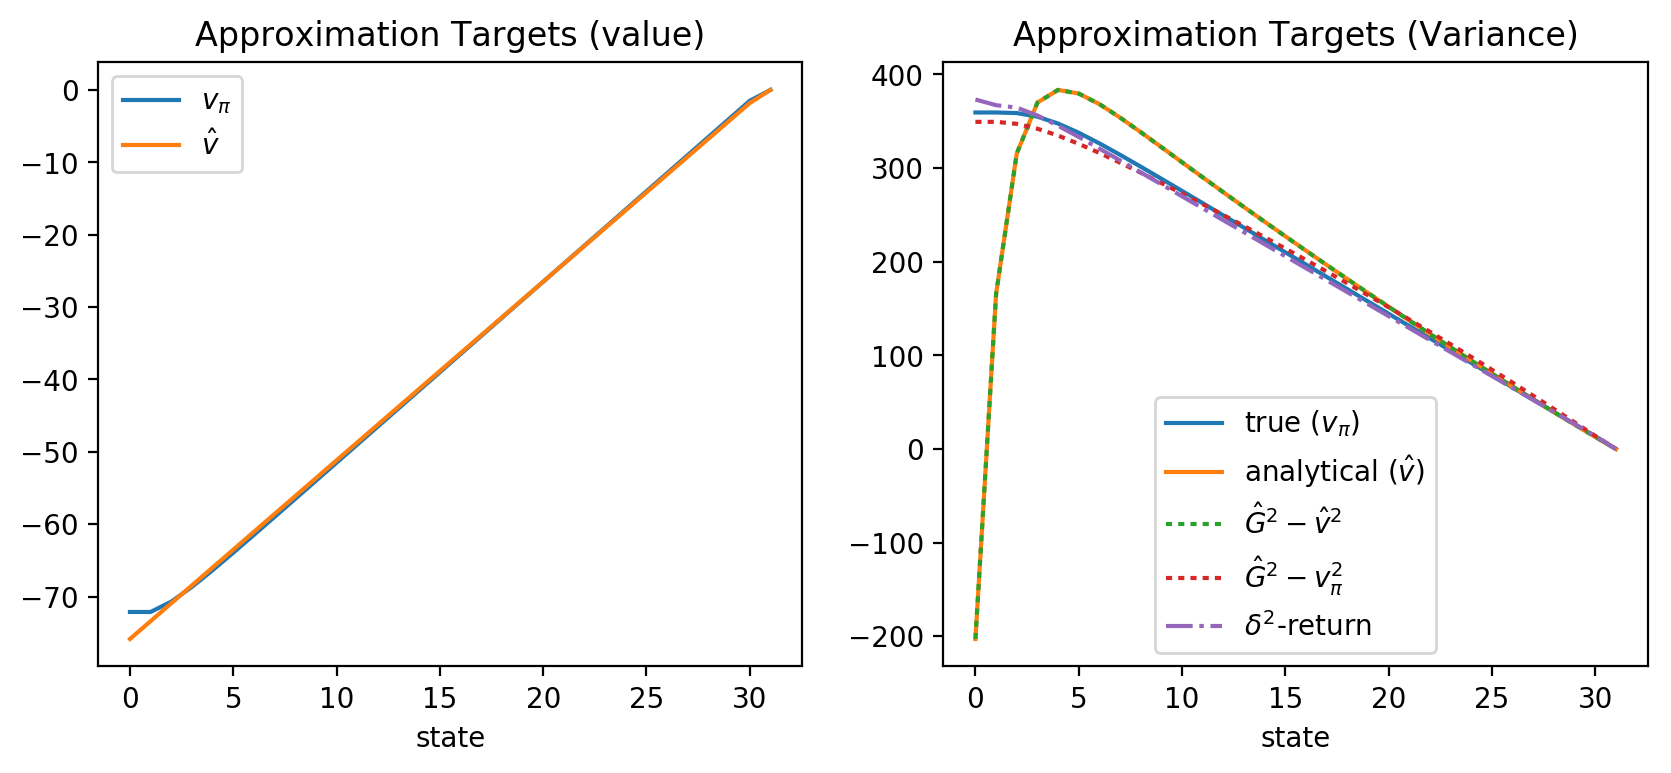

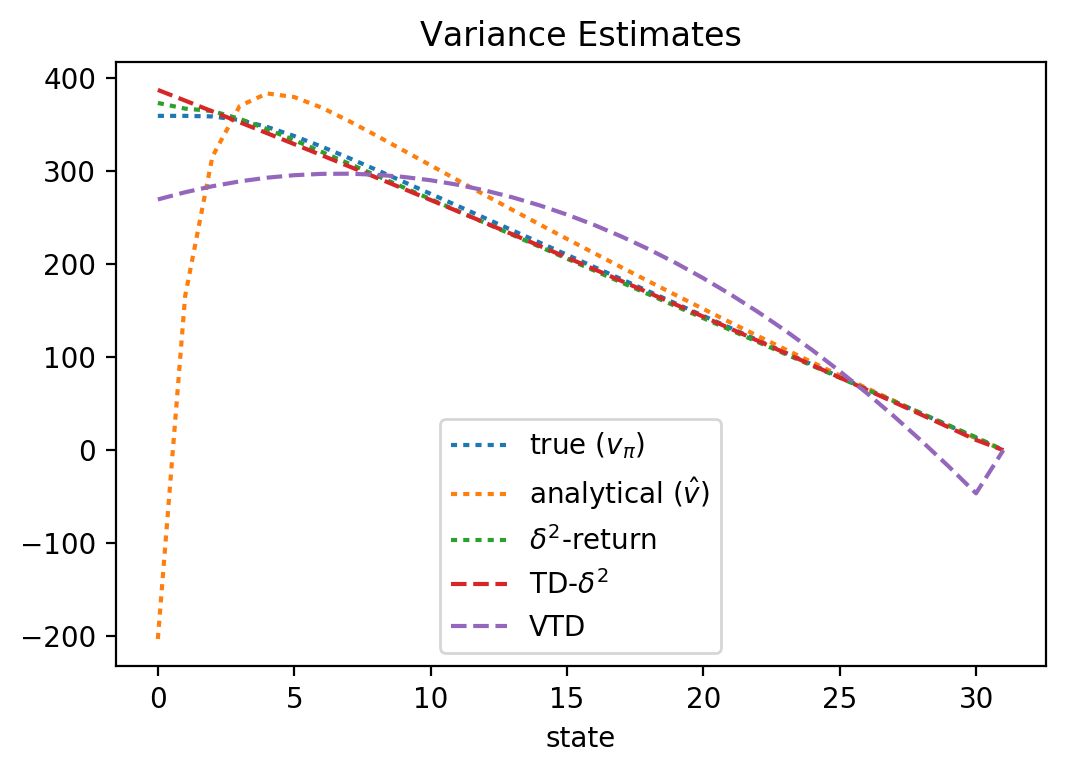

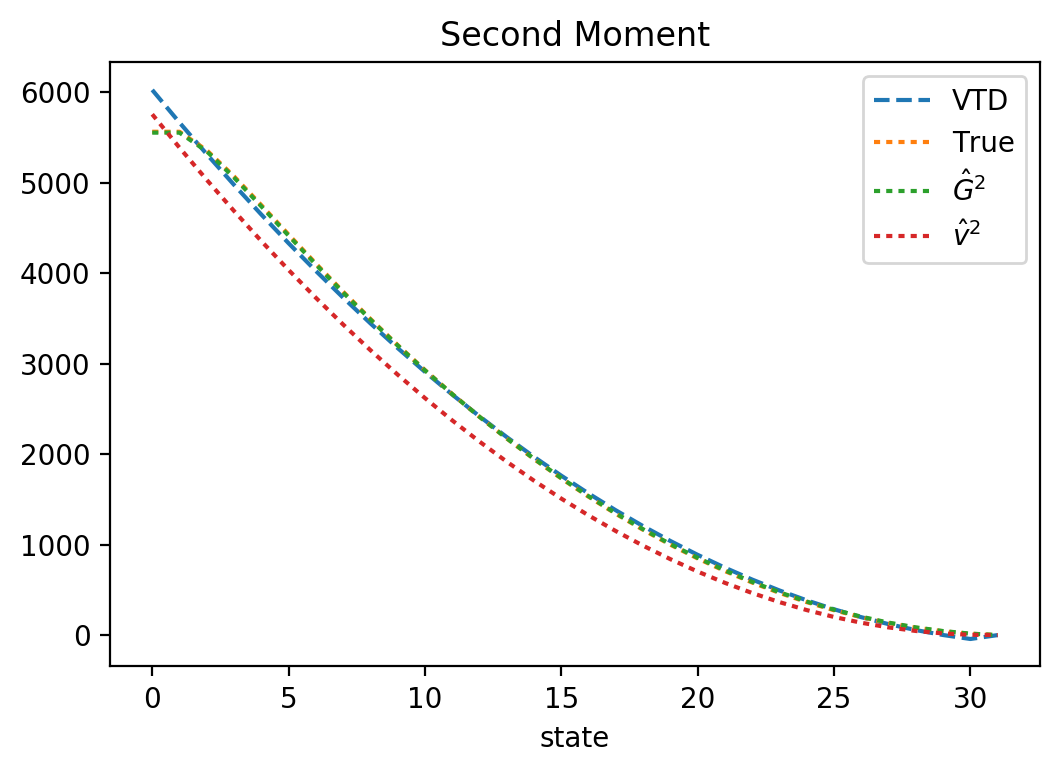

In [14]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# Value function
ax = axes[0]
ax.plot(v_pi, label='$v_{\pi}$')
ax.plot(v_hat, label='$\hat{v}$')

ax.set_title('Approximation Targets (value)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

# Variance
ax = axes[1]
ax.plot(v_var, label='true ($v_{\pi}$)', linestyle='-')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle='-')
ax.plot((g_second - v_hat**2),  label='$\hat{G}^{2} - \hat{v}^{2}$', linestyle=':')
ax.plot((g_second - v_pi**2),  label='$\hat{G}^{2} - v_{\pi}^{2}$', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle='-.')

ax.set_title('Approximation Targets (Variance)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Estimates
fig, ax = plt.subplots()

ax.plot(v_var, label='true ($v_{\pi}$)', linestyle=':')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle=':')
ax.plot(v_tdsq, label='TD-$\delta^2$', linestyle='--')
ax.plot(v_vtd,  label='VTD', linestyle='--')

ax.set_title('Variance Estimates')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Second Moment
fig, ax = plt.subplots()

ax.plot(v_sm, label='VTD', linestyle='--')
ax.plot(v_var + v_pi**2, label='True', linestyle=':')
ax.plot(g_second, label='$\hat{G}^{2}$', linestyle=':')
ax.plot(v_hat**2, label='$\hat{v}^{2}$', linestyle=':')

ax.set_title('Second Moment')
ax.set_xlabel('state')
ax.set_ylabel('')

ax.legend()
plt.show()

### λ = 0.95

In [15]:
# Compute TD(λ) fixed point
L = np.eye(ns)*0.95
w_hat = mdpy.td_weights(P, r, G, L, X)
v_hat = X @ w_hat

# Bias of approximate value function
bias = v_pi - v_hat

# Variance using Sobel's method and approximate value function
T_hat = (P * (R + G @ v_hat)**2) @ np.ones(ns) - v_hat**2

        
# Solve Bellman equation for variance of return w/ approx value function
var_hat = pinv(I - P @ G @ G) @ T_hat
var_hat[-1] = 0 # terminal state

# Second moment target (see earlier in notebook for alternate calculation method)
r_bar = (P*R**2) @ np.ones(ns) + (2*P @ G * R) @ v_hat
g_second = pinv(I - P @ G @ G)@(r_bar)
g_second[-1] = 0 # hacky way of setting terminal SM to zero

# TD error matrix, for error given transition i-->j
Δ = np.zeros_like(R)
for i in range(ns):
    for j in range(ns):
        Δ[i,j] = (R[i,j] + gvec[j]*v_hat[j] - v_hat[i])

# Expected TD-error
δ = (P*Δ) @ np.ones(ns)
δ[-1] = 0 # terminal state
        
# Expected δ^2
δ_sq = (P * Δ**2) @ np.ones(ns)
δ_sq[-1] = 0 # terminal state

# δ-return
gd = pinv(I - P @ G) @ δ

# δ^2-return
gd_sq = pinv(I - P @ G @ G) @ δ_sq
gd_sq[-1] = 0 # terminal state

# Second moment of δ-return (for MSE comparison)
dd = (P * Δ**2) @ np.ones(ns) + (2*P @ G * Δ) @ gd
gd_second = pinv(I - P @ G @ G)@(dd)
gd_second[-1] = 0 # terminal state

###################### Function Approximation ######################
K_bar = np.eye(ns)               # kappa 
L_bar = np.eye(ns)               # λ-bar
G_bar = (G @ G @ K_bar @ K_bar)  # discount factor

# TD-δ^2 fixed point
w_tdsq = mdpy.td_weights(P, δ_sq, G_bar, L_bar, X_bar)
v_tdsq = X_bar @ w_tdsq

# Second moment method fixed point
w_sm   = mdpy.td_weights(P, r_bar, G_bar, L_bar, X_bar)
v_sm   = X_bar @ w_sm
v_vtd  = v_sm - v_hat**2

####################################################################
# Print summary of results
print("v_π:\n", v_pi)
print("v_hat:\n", v_hat)
print("(Sobel) Approximate variance of return:\n", var_hat)
print("(Sobel) True variance of return:\n", v_var)

# Variance and second moment
print('-'*80)
print('Expected TD-error:\n', δ)
print('Expected Squared TD-error:\n', δ_sq)
print("Second moment expected 'reward' (r-bar):\n", r_bar)
print('Approximate second moment return:\n', g_second)
print("δ^2-return:\n", gd_sq)

print('-'*80)
print('(FA) TD-δ^2 values:\n', v_tdsq)
print('(FA) VTD second moment values:\n', v_sm)
print('(FA) VTD variance values:\n', v_vtd)

# Neat results
print('-'*80)
# Bias is the δ-return
# print("bias:\n", v_pi-v_hat)
# print("δ-return:\n", gd)

# Second moment of δ-return is the expected squared error
# print("Second moment of delta-return:\n", gd_second)
# print("Expected squared error:\n", (v_pi - v_hat)**2 + v_var)



v_π:
 [-72.125  -72.125  -70.6964 -68.6556 -66.3524 -63.9367 -61.4729 -58.9884
 -56.495  -53.9979 -51.4991 -48.9996 -46.4998 -43.9999 -41.5    -39.     -36.5
 -34.     -31.5    -29.     -26.5    -24.     -21.5    -19.     -16.5    -14.
 -11.5     -9.      -6.5     -4.      -1.5      0.    ]
v_hat:
 [-75.5508 -73.1023 -70.6539 -68.2054 -65.757  -63.3085 -60.8601 -58.4116
 -55.9632 -53.5147 -51.0663 -48.6178 -46.1694 -43.7209 -41.2725 -38.824
 -36.3756 -33.9271 -31.4787 -29.0302 -26.5818 -24.1333 -21.6849 -19.2364
 -16.788  -14.3395 -11.8911  -9.4426  -6.9942  -4.5457  -2.0973   0.    ]
(Sobel) Approximate variance of return:
 [-156.7805  207.1891  353.7735  405.2384  416.082   409.6608  395.9846
  379.3433  361.5756  343.4693  325.3622  307.399   289.6417  272.1169
  254.836   237.8039  221.0226  204.4931  188.2158  172.1907  156.4181
  140.8978  125.63    110.6146   95.8516   81.3411   67.083    53.0773
   39.3241   25.8233   12.575     0.    ]
(Sobel) True variance of return:
 [ 359.2

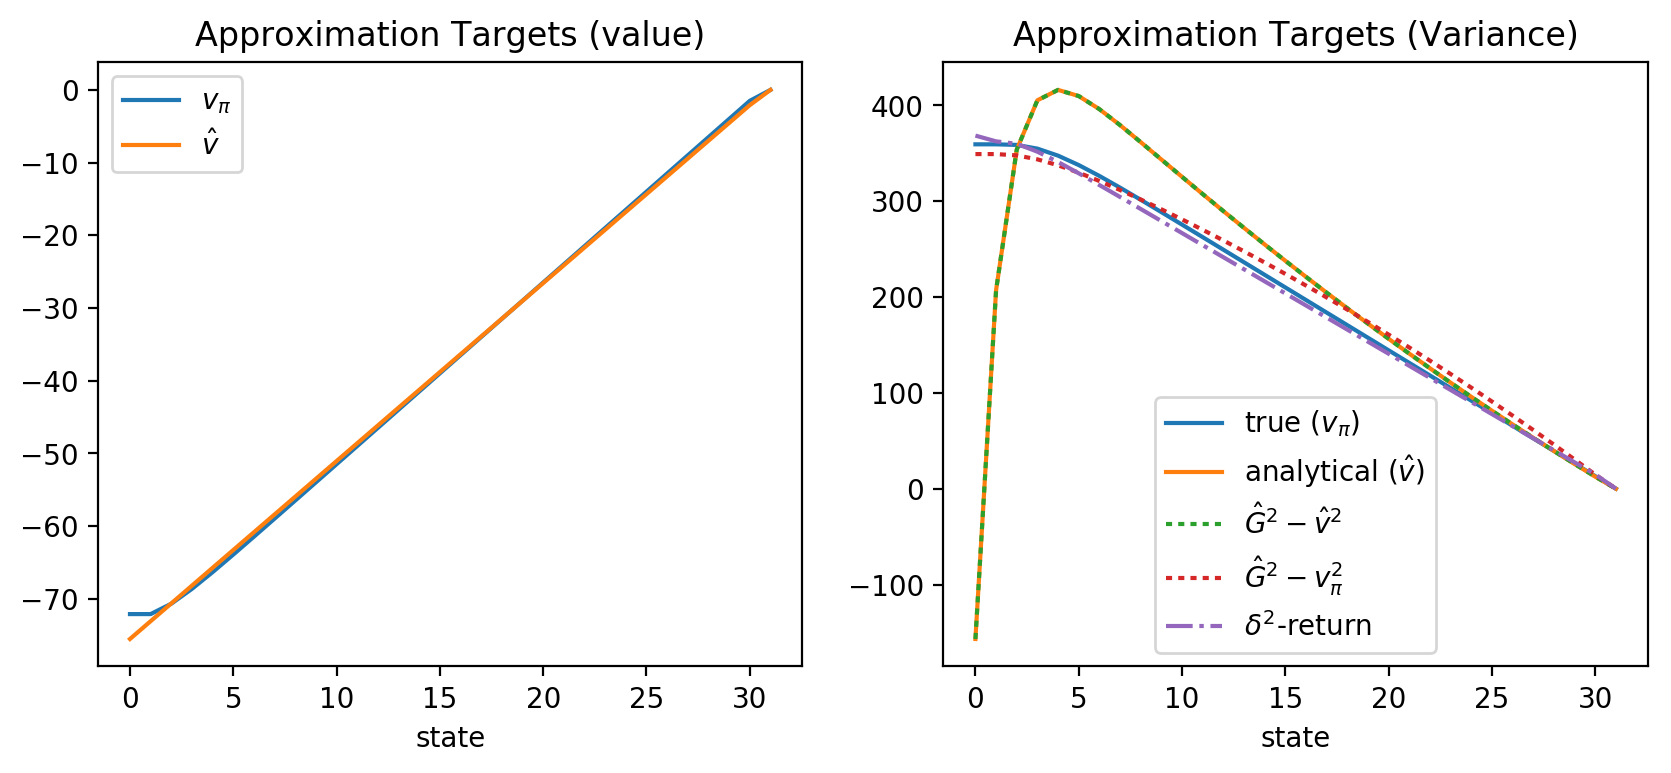

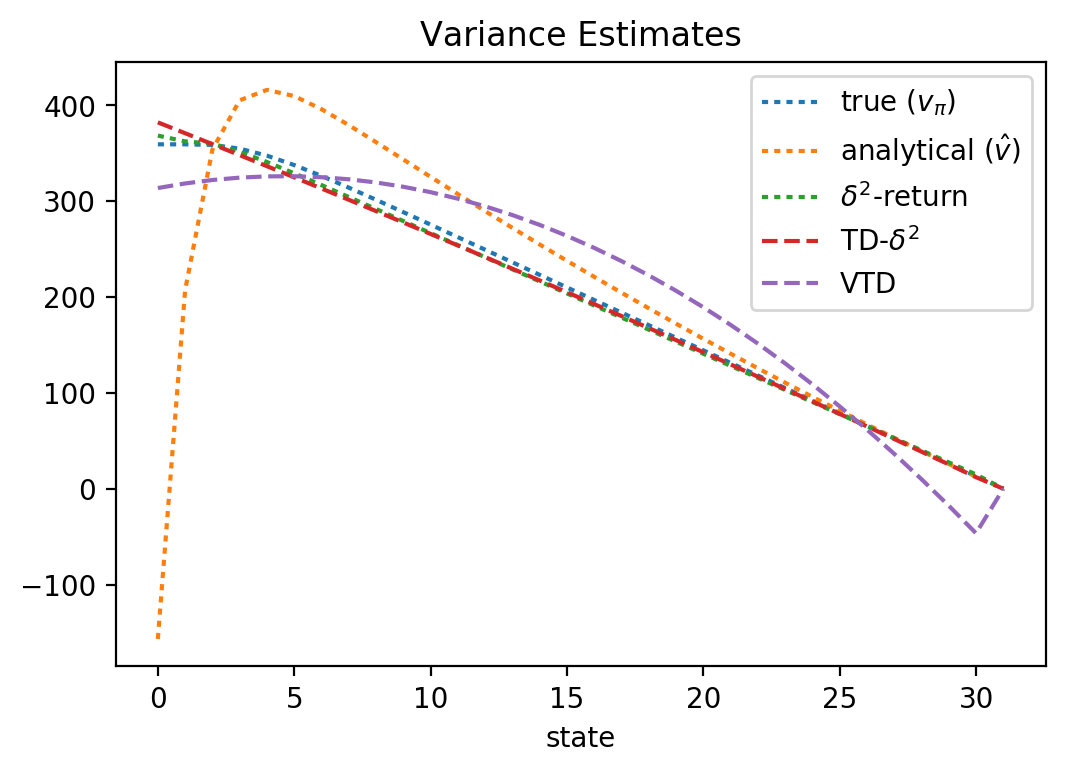

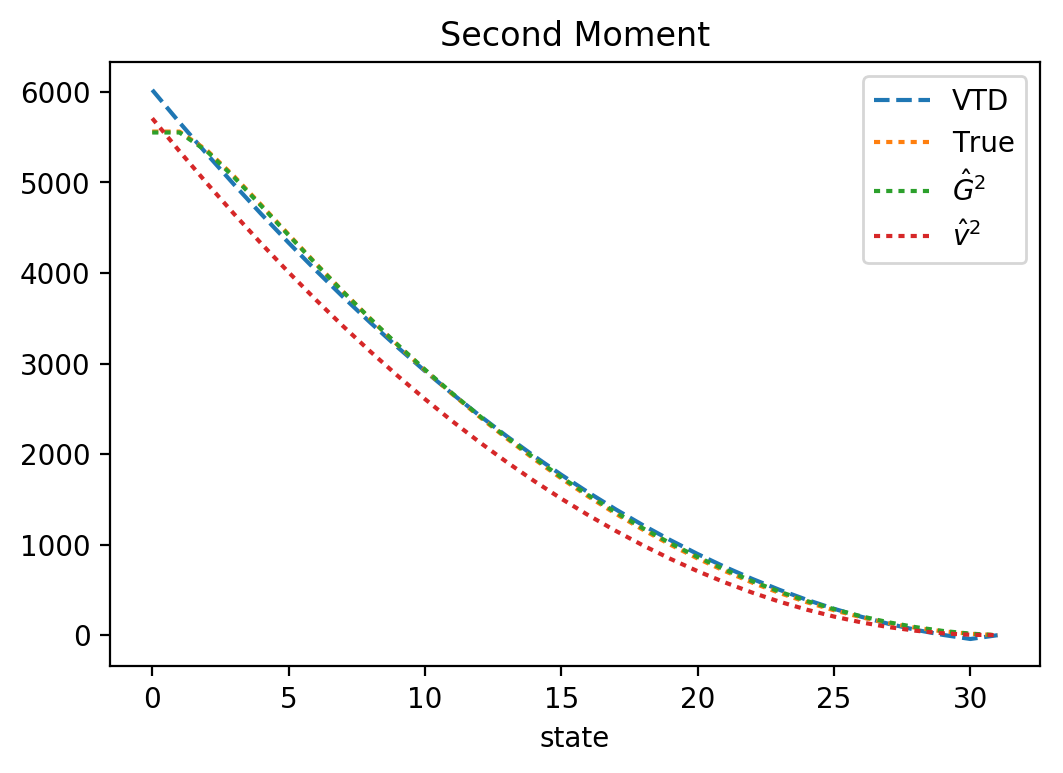

In [16]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# Value function
ax = axes[0]
ax.plot(v_pi, label='$v_{\pi}$')
ax.plot(v_hat, label='$\hat{v}$')

ax.set_title('Approximation Targets (value)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

# Variance
ax = axes[1]
ax.plot(v_var, label='true ($v_{\pi}$)', linestyle='-')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle='-')
ax.plot((g_second - v_hat**2),  label='$\hat{G}^{2} - \hat{v}^{2}$', linestyle=':')
ax.plot((g_second - v_pi**2),  label='$\hat{G}^{2} - v_{\pi}^{2}$', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle='-.')

ax.set_title('Approximation Targets (Variance)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Estimates
fig, ax = plt.subplots()

ax.plot(v_var, label='true ($v_{\pi}$)', linestyle=':')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle=':')
ax.plot(v_tdsq, label='TD-$\delta^2$', linestyle='--')
ax.plot(v_vtd,  label='VTD', linestyle='--')

ax.set_title('Variance Estimates')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Second Moment
fig, ax = plt.subplots()

ax.plot(v_sm, label='VTD', linestyle='--')
ax.plot(v_var + v_pi**2, label='True', linestyle=':')
ax.plot(g_second, label='$\hat{G}^{2}$', linestyle=':')
ax.plot(v_hat**2, label='$\hat{v}^{2}$', linestyle=':')

ax.set_title('Second Moment')
ax.set_xlabel('state')
ax.set_ylabel('')

ax.legend()
plt.show()

### v = v_π

And here we check what the fixed points for the TD-δ^2 and VTD algorithms are assuming the value function is exact.

In [17]:
# Use the true value function as v_hat
v_hat = v_pi.copy()

# Bias of approximate value function
bias = v_pi - v_hat

# Variance using Sobel's method and approximate value function
T_hat = (P * (R + G @ v_hat)**2) @ np.ones(ns) - v_hat**2
        
# Solve Bellman equation for variance of return w/ approx value function
var_hat = pinv(I - P @ G @ G) @ T_hat
var_hat[-1] = 0 # terminal state

# Second moment target (see earlier in notebook for alternate calculation method)
r_bar = (P*R**2) @ np.ones(ns) + (2*P @ G * R) @ v_hat
g_second = pinv(I - P @ G @ G)@(r_bar)
g_second[-1] = 0 # hacky way of setting terminal SM to zero

# TD error matrix, for error given transition i-->j
Δ = np.zeros_like(R)
for i in range(ns):
    for j in range(ns):
        Δ[i,j] = (R[i,j] + gvec[j]*v_hat[j] - v_hat[i])

# Expected TD-error
δ = (P*Δ) @ np.ones(ns)
δ[-1] = 0 # terminal state
        
# Expected δ^2
δ_sq = (P * Δ**2) @ np.ones(ns)
δ_sq[-1] = 0 # terminal state

# δ-return
gd = pinv(I - P @ G) @ δ

# δ^2-return
gd_sq = pinv(I - P @ G @ G) @ δ_sq
gd_sq[-1] = 0 # terminal state

# Second moment of δ-return (for MSE comparison)
dd = (P * Δ**2) @ np.ones(ns) + (2*P @ G * Δ) @ gd
gd_second = pinv(I - P @ G @ G)@(dd)
gd_second[-1] = 0 # terminal state

###################### Function Approximation ######################
K_bar = np.eye(ns)               # kappa 
L_bar = np.eye(ns)               # λ-bar
G_bar = (G @ G @ K_bar @ K_bar)  # discount factor

# TD-δ^2 fixed point
w_tdsq = mdpy.td_weights(P, δ_sq, G_bar, L_bar, X_bar)
v_tdsq = X_bar @ w_tdsq

# Second moment method fixed point
w_sm   = mdpy.td_weights(P, r_bar, G_bar, L_bar, X_bar)
v_sm   = X_bar @ w_sm
v_vtd  = v_sm - v_hat**2

####################################################################
# Print summary of results
print("v_π:\n", v_pi)
print("v_hat:\n", v_hat)
print("(Sobel) Approximate variance of return:\n", var_hat)
print("(Sobel) True variance of return:\n", v_var)

# Variance and second moment
print('-'*80)
print('Expected TD-error:\n', δ)
print('Expected Squared TD-error:\n', δ_sq)
print("Second moment expected 'reward' (r-bar):\n", r_bar)
print('Approximate second moment return:\n', g_second)
print("δ^2-return:\n", gd_sq)

print('-'*80)
print('(FA) TD-δ^2 values:\n', v_tdsq)
print('(FA) VTD second moment values:\n', v_sm)
print('(FA) VTD variance values:\n', v_vtd)

# Neat results
print('-'*80)
# Bias is the δ-return
# print("bias:\n", v_pi-v_hat)
# print("δ-return:\n", gd)

# Second moment of δ-return is the expected squared error
# print("Second moment of delta-return:\n", gd_second)
# print("Expected squared error:\n", (v_pi - v_hat)**2 + v_var)



v_π:
 [-72.125  -72.125  -70.6964 -68.6556 -66.3524 -63.9367 -61.4729 -58.9884
 -56.495  -53.9979 -51.4991 -48.9996 -46.4998 -43.9999 -41.5    -39.     -36.5
 -34.     -31.5    -29.     -26.5    -24.     -21.5    -19.     -16.5    -14.
 -11.5     -9.      -6.5     -4.      -1.5      0.    ]
v_hat:
 [-72.125  -72.125  -70.6964 -68.6556 -66.3524 -63.9367 -61.4729 -58.9884
 -56.495  -53.9979 -51.4991 -48.9996 -46.4998 -43.9999 -41.5    -39.     -36.5
 -34.     -31.5    -29.     -26.5    -24.     -21.5    -19.     -16.5    -14.
 -11.5     -9.      -6.5     -4.      -1.5      0.    ]
(Sobel) Approximate variance of return:
 [ 359.2969  359.2969  358.6846  354.8112  347.4901  337.6721  326.3215
  314.1111  301.4443  288.5441  275.5276  262.4543  249.3538  236.2402
  223.1205  209.9979  196.8741  183.7496  170.6248  157.4999  144.375
  131.25    118.125   105.       91.875    78.75     65.625    52.5
   39.375    26.25     13.125     0.    ]
(Sobel) True variance of return:
 [ 359.2969  359.2

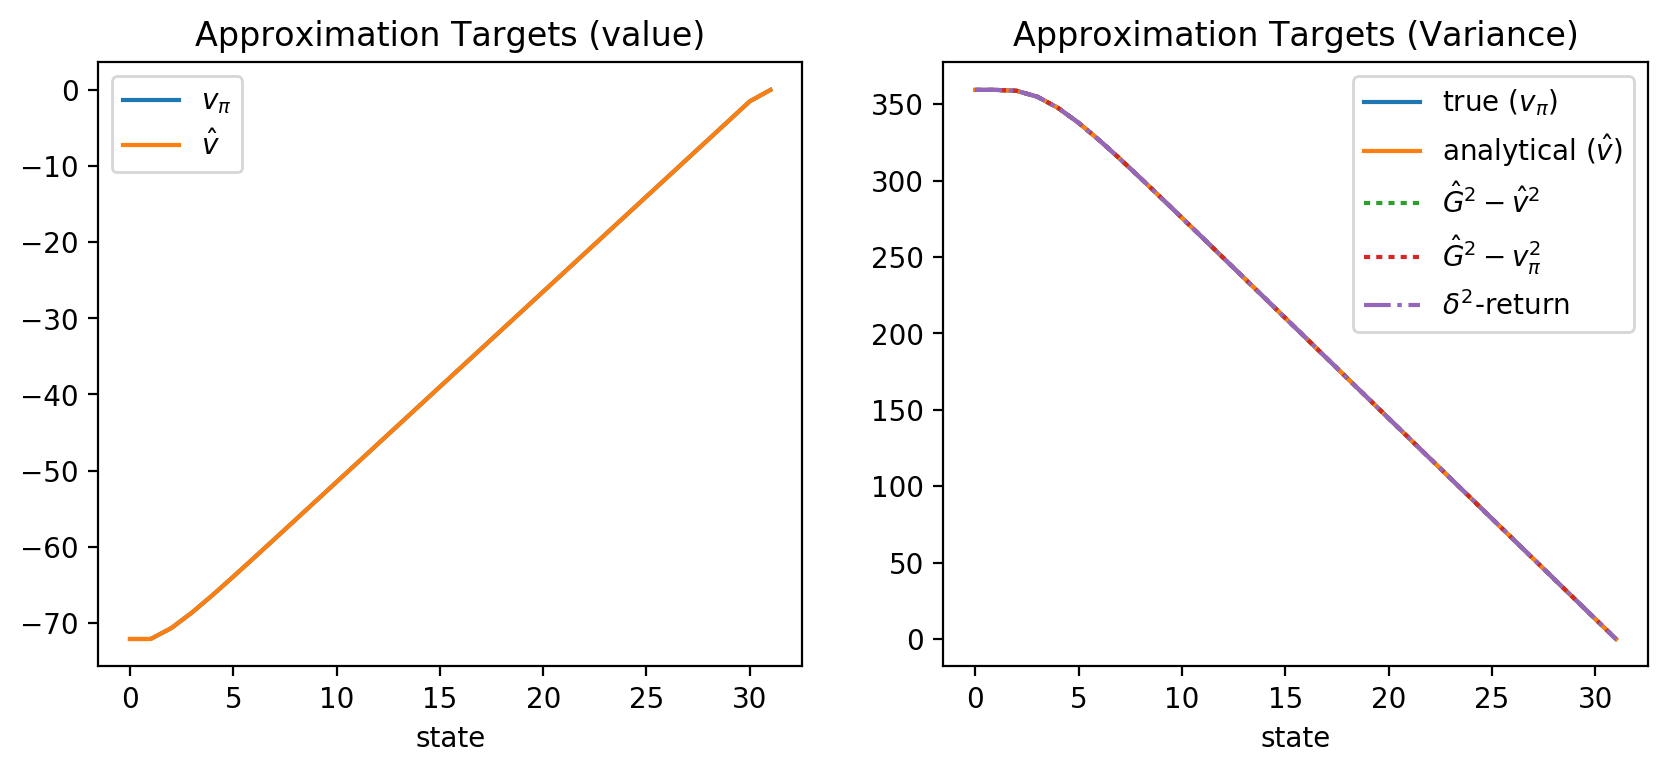

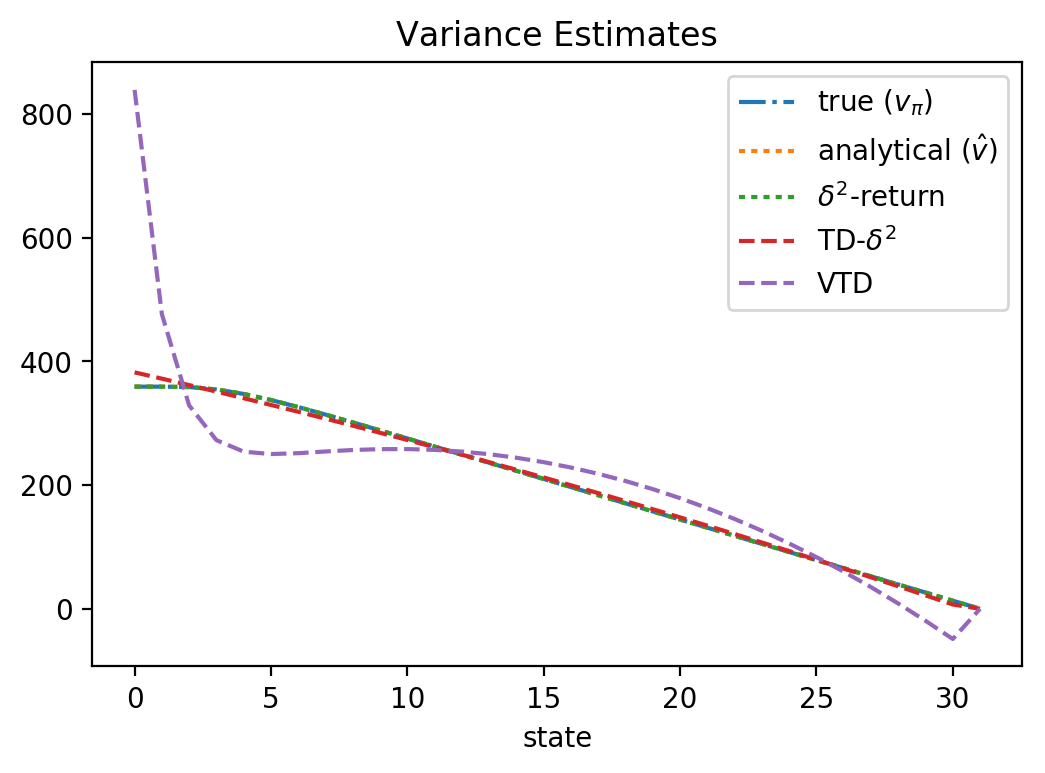

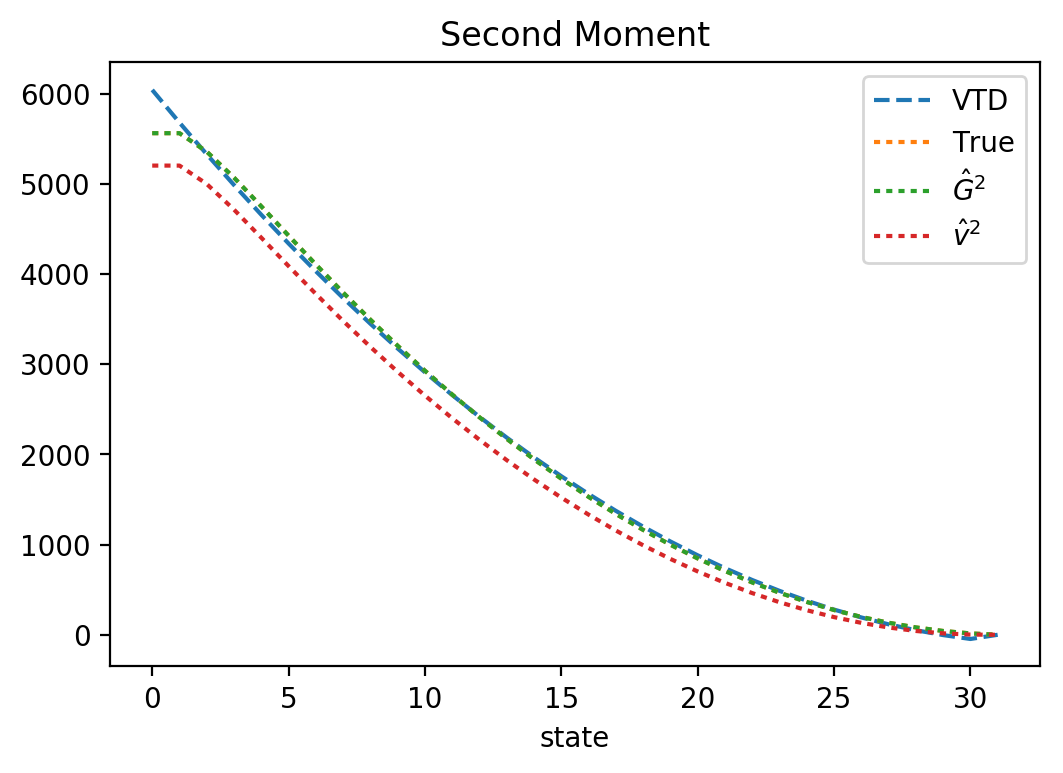

In [18]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# Value function
ax = axes[0]
ax.plot(v_pi, label='$v_{\pi}$')
ax.plot(v_hat, label='$\hat{v}$')

ax.set_title('Approximation Targets (value)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

# Variance
ax = axes[1]
ax.plot(v_var, label='true ($v_{\pi}$)', linestyle='-')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle='-')
ax.plot((g_second - v_hat**2),  label='$\hat{G}^{2} - \hat{v}^{2}$', linestyle=':')
ax.plot((g_second - v_pi**2),  label='$\hat{G}^{2} - v_{\pi}^{2}$', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle='-.')

ax.set_title('Approximation Targets (Variance)')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Estimates
fig, ax = plt.subplots()

ax.plot(v_var, label='true ($v_{\pi}$)', linestyle='-.')
ax.plot(var_hat, label='analytical ($\hat{v}$)', linestyle=':')
ax.plot(gd_sq, label='$\delta^{2}$-return', linestyle=':')
ax.plot(v_tdsq, label='TD-$\delta^2$', linestyle='--')
ax.plot(v_vtd,  label='VTD', linestyle='--')

ax.set_title('Variance Estimates')
ax.set_xlabel('state')
ax.set_ylabel('')
ax.legend()

plt.show()


#### Second Moment
fig, ax = plt.subplots()

ax.plot(v_sm, label='VTD', linestyle='--')
ax.plot(v_var + v_pi**2, label='True', linestyle=':')
ax.plot(g_second, label='$\hat{G}^{2}$', linestyle=':')
ax.plot(v_hat**2, label='$\hat{v}^{2}$', linestyle=':')

ax.set_title('Second Moment')
ax.set_xlabel('state')
ax.set_ylabel('')

ax.legend()
plt.show()